# Creating and Training MLP
### Imports and reading

In [1]:
import os, math, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import metrics

import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile

dataset = pd.read_csv('../data/SIMULATION/Dataset_refined/complete.csv', sep=',')
dataset = dataset.drop(['velocity'], axis=1)
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:,-1].values

MODEL_NAME = 'model/mlp-full.h5'

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Dataset Information

In [2]:
right_turns = y[np.where(y > 0.1)]
left_turns = y[np.where(y < -0.1)]
straight = y[np.where(abs(y) < 0.1)]
print("Training Size: ", y.shape[0])
print("Number of Straight: ", straight.shape[0])
print("Number of right turns: ", right_turns.shape[0])
print("Number of left turns: ", left_turns.shape[0])
print("max: ", np.amax(y))
print("median: ", np.median(y))
print("min: ", np.amin(y))
dataset.describe()

Training Size:  31963
Number of Straight:  16889
Number of right turns:  8618
Number of left turns:  6456
max:  0.4189
median:  0.00270683760755
min:  -0.4189


,0,1,2,3,4,5,6,7,8,9,...,1072,1073,1074,1075,1076,1077,1078,1079,1080,steering_angle
count,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,...,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000,31963.000000
mean,1.743029,1.733752,1.722439,1.716241,1.709489,1.700791,1.694084,1.686015,1.675439,1.667171,...,1.724487,1.729072,1.746218,1.759561,1.773385,1.805611,1.805835,1.834496,1.842745,0.015533
std,1.020810,1.013127,0.940790,1.003551,1.061640,1.057337,1.112171,1.109524,1.048302,1.045476,...,4.411267,4.505024,4.594362,4.611814,4.640333,4.776702,4.659846,4.768705,4.755186,0.202335
min,0.295000,0.297000,0.295000,0.287000,0.286000,0.285000,0.285000,0.282000,0.280000,0.282000,...,0.118000,0.093000,0.104000,0.104000,0.101000,0.104000,0.097000,0.103000,0.109000,-0.418900
25%,1.151000,1.146000,1.141000,1.135000,1.129000,1.123976,1.118000,1.113000,1.108850,1.103105,...,0.911000,0.904999,0.909813,0.916000,0.922995,0.929442,0.936000,0.942441,0.950000,-0.072035
50%,1.540000,1.531000,1.523000,1.515034,1.509000,1.502000,1.496000,1.487000,1.478000,1.470000,...,1.157442,1.156060,1.163417,1.170679,1.178000,1.185894,1.193000,1.198562,1.206000,0.002707
75%,1.905904,1.896946,1.884265,1.869373,1.856463,1.847000,1.840111,1.828881,1.820000,1.807000,...,1.439113,1.441152,1.453984,1.468024,1.480000,1.495760,1.509000,1.523000,1.534000,0.113472
max,65.532997,65.532997,8.132000,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,...,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,65.532997,0.418900


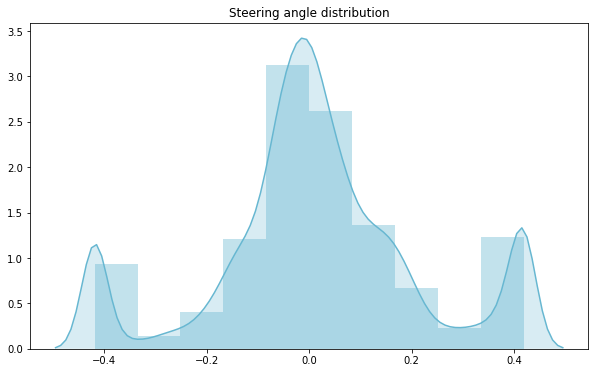

In [3]:
fig = plt.figure(figsize=(10,6))
sns.distplot(y, bins=10, hist=True, kde_kws={"shade": True}, color='#67B7D1')# green - #3cb44b, blue - #67B7D1
plt.title('Steering angle distribution', loc='center')
plt.show()

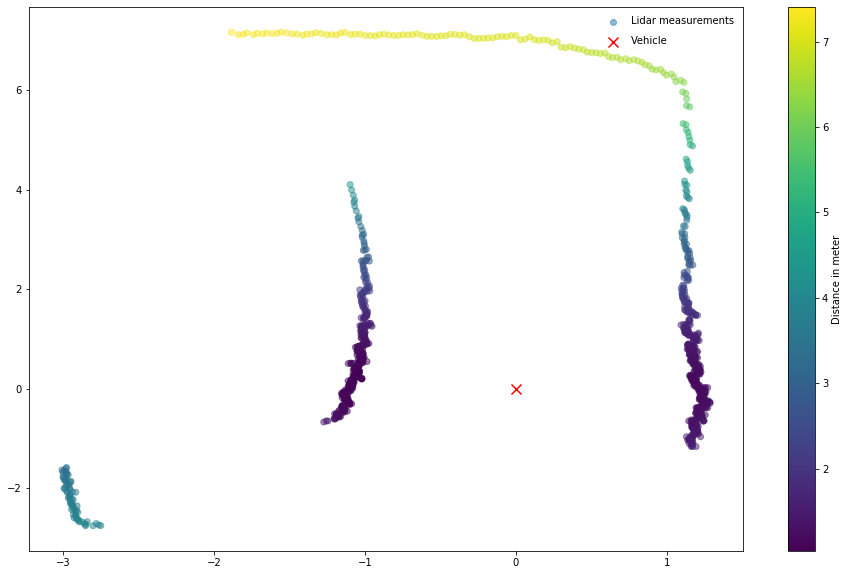

Output:  0.0248683169484


In [4]:
angle_inc = math.radians(0.25)
angle_start = -math.radians(45)

SEQ_IDX = 500
data_plot = X[SEQ_IDX]

x_ = []
y_ = []

for i in range(len(data_plot)):
    angle = angle_start + i * angle_inc
    x_.append(data_plot[i]*math.cos(angle))
    y_.append(data_plot[i]*math.sin(angle))

norm = mpl.colors.Normalize(vmin=np.amin(data_plot), vmax=np.amax(data_plot))

fig = plt.figure(figsize=(16,10))
plt.scatter(x_,y_, c=(data_plot), cmap='viridis', marker='o', alpha=0.5, label='Lidar measurements')
plt.scatter(x=0, y=0,s=100, c='r', marker="x", label='Vehicle')
plt.axis(aspect='equal')

plt.colorbar(mpl.cm.ScalarMappable(norm=norm), label='Distance in meter')
plt.legend(labelspacing=1,frameon=False)
plt.show()
print("Output: ", y[SEQ_IDX])

### Create Keras Model

In [5]:
inputs = Input(shape=(360,), name="input_layer")

dense1 = Dense(32, name="dense_layer_1")(inputs)
dense1 = Activation("relu")(dense1)

dense2 = Dense(64, name="dense_layer_2")(dense1)
dense2 = Activation("relu")(dense2)

dense3 = Dense(32, name="dense_layer_3")(dense2)
dense3 = Activation("relu")(dense3)

final = Dense(1, name="output_layer")(dense3)

model = Model(inputs=inputs, outputs=final)

model.compile(loss='mean_squared_error',
              optimizer= Adam(), metrics=[metrics.mae])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 360)]             0         
_________________________________________________________________
dense_layer_1 (Dense)        (None, 32)                11552     
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_layer_2 (Dense)        (None, 64)                2112      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_layer_3 (Dense)        (None, 32)                2080      
______________________________________________

### Preprocess input
##### Make the input smaller, limit the view and use every other measurement

In [2]:
#preproccess 45 degrees = 180 iter
def preprocess(lidar):
    new_list = []
    for i in range (180, 900):
        if(i % 2 == 0):
            new_list.append(np.clip(lidar[i], 0, 15.0))
    return np.array(new_list)
    

In [7]:
processed_data = []

for x in X:
    processed_data.append(preprocess(x))

processed_data = np.array(processed_data)

scaler = MinMaxScaler()
scaler.fit(processed_data)
processed_data = scaler.transform(processed_data)


x_t, x_v, y_t, y_v = train_test_split(processed_data, y, test_size=0.15, random_state=0)

## Train Model

In [9]:
BATCH_SIZE = 24 
EPOCHS = 30

history = model.fit(x_t,y_t,
                    verbose=1,
                    epochs= EPOCHS,
                    validation_data=(x_v,y_v))

Train on 27168 samples, validate on 4795 samples
Epoch 1/30
27168/27168 [==============================] - 2s 62us/sample - loss: 0.0114 - mean_absolute_error: 0.0760 - val_loss: 0.0086 - val_mean_absolute_error: 0.0643
Epoch 2/30
27168/27168 [==============================] - 1s 53us/sample - loss: 0.0086 - mean_absolute_error: 0.0651 - val_loss: 0.0076 - val_mean_absolute_error: 0.0615
Epoch 3/30
27168/27168 [==============================] - 2s 73us/sample - loss: 0.0075 - mean_absolute_error: 0.0601 - val_loss: 0.0064 - val_mean_absolute_error: 0.0540
Epoch 4/30
27168/27168 [==============================] - 2s 80us/sample - loss: 0.0068 - mean_absolute_error: 0.0569 - val_loss: 0.0063 - val_mean_absolute_error: 0.0547
Epoch 5/30
27168/27168 [==============================] - 2s 81us/sample - loss: 0.0065 - mean_absolute_error: 0.0554 - val_loss: 0.0062 - val_mean_absolute_error: 0.0529
Epoch 6/30
27168/27168 [==============================] - 2s 75us/sample - loss: 0.0061 - mean_a

### Save Keras Model

In [10]:
model.save(MODEL_NAME)

## Load Keras Model and Export to Tensorflow model

In [14]:
tf.keras.backend.set_learning_phase(0) 

MODEL_PATH = "./model/mlp-full/mlp-full"

model = load_model('./model/mlp-full.h5')

saver = tf.train.Saver()
sess = tf.keras.backend.get_session()
save_path = saver.save(sess, MODEL_PATH)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
#tf to TFRT
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.50))) as sess:
    saver = tf.train.import_meta_graph(MODEL_PATH + ".meta")
    saver.restore(sess, MODEL_PATH)
    
    output_nodes = ["output_layer/BiasAdd"] #output layer
    
    # convert to frozen model
    frozen_graph = tf.compat.v1.graph_util.convert_variables_to_constants(
        sess, 
        tf.get_default_graph().as_graph_def(),
        output_node_names=output_nodes)
    
    with gfile.FastGFile("./model/frozen_model.pb", 'wb') as f:
        f.write(frozen_graph.SerializeToString())

INFO:tensorflow:Restoring parameters from ./model/mlp-full/mlp-full
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.
Instructions for updating:
Use tf.gfile.GFile.


In [4]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['input_layer',
 'dense_layer_1/kernel/Initializer/random_uniform/shape',
 'dense_layer_1/kernel/Initializer/random_uniform/min',
 'dense_layer_1/kernel/Initializer/random_uniform/max',
 'dense_layer_1/kernel/Initializer/random_uniform/RandomUniform',
 'dense_layer_1/kernel/Initializer/random_uniform/sub',
 'dense_layer_1/kernel/Initializer/random_uniform/mul',
 'dense_layer_1/kernel/Initializer/random_uniform',
 'dense_layer_1/kernel',
 'dense_layer_1/kernel/IsInitialized/VarIsInitializedOp',
 'dense_layer_1/kernel/Assign',
 'dense_layer_1/kernel/Read/ReadVariableOp',
 'dense_layer_1/bias/Initializer/zeros',
 'dense_layer_1/bias',
 'dense_layer_1/bias/IsInitialized/VarIsInitializedOp',
 'dense_layer_1/bias/Assign',
 'dense_layer_1/bias/Read/ReadVariableOp',
 'dense_layer_1/MatMul/ReadVariableOp',
 'dense_layer_1/MatMul',
 'dense_layer_1/BiasAdd/ReadVariableOp',
 'dense_layer_1/BiasAdd',
 'activation/Relu',
 'dense_layer_2/kernel/Initializer/random_uniform/shape',
 'dense_layer_2/kerne

In [16]:
trt_graph = trt.create_inference_graph(
    input_graph_def=frozen_graph,
    outputs=output_nodes,
    max_batch_size=2,# specify your max batch size
    max_workspace_size_bytes=2*(10**9),# specify the max workspace
    precision_mode="FP32") # precision, can be "FP32" (32 floating point precision) or "FP16"

with gfile.FastGFile("./model/TensorRT_model.pb", 'wb') as f:
    f.write(trt_graph.SerializeToString())

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Running against TensorRT version 0.0.0


In [17]:
# check how many ops of the original frozen model
all_nodes = len([1 for n in frozen_graph.node])
print("numb. of all_nodes in frozen graph:", all_nodes)

# check how many ops that is converted to TensorRT engine
trt_engine_nodes = len([1 for n in trt_graph.node if str(n.op) == 'TRTEngineOp'])
print("numb. of trt_engine_nodes in TensorRT graph:", trt_engine_nodes)
all_nodes = len([1 for n in trt_graph.node])
print("numb. of all_nodes in TensorRT graph:", all_nodes)

numb. of all_nodes in frozen graph: 28
numb. of trt_engine_nodes in TensorRT graph: 0
numb. of all_nodes in TensorRT graph: 20


## Prediction

In [3]:
def read_pb_graph(model):
    with gfile.FastGFile(model,'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    return graph_def

In [32]:
import tensorflow as tf
tf.keras.backend.set_learning_phase(0) 
from tensorflow.keras.models import load_model
import tensorflow.contrib.tensorrt as trt
from tensorflow.python.platform import gfile
import numpy as np
import time

TENSORRT_MODEL_PATH = './model/TensorRT_model.pb'

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))) as sess:
        
        trt_graph = read_pb_graph(TENSORRT_MODEL_PATH)

        # obtain the corresponding input-output tensor
        tf.import_graph_def(trt_graph, name='')
        input_ = sess.graph.get_tensor_by_name('input_layer:0')
        output_ = sess.graph.get_tensor_by_name('output_layer/BiasAdd:0')
        
        lidar_func = lambda x : x if x <= 15.0 else 15.0
        
        actions_ = pd.read_csv('../data/SIMULATION/RACE_1_TEST/straight_right_turn/actions.txt', sep=' ')
        lidars_ = pd.read_csv('../data/SIMULATION/RACE_1_TEST/straight_right_turn/lidar.txt', sep=' ')

        X = lidars_.iloc[:,:].values
        y = actions_.iloc[:,0].values
        tot_time = 0
        error = 0
        count_wrong_dir = 0
        counter = 0
        for j in range(len(X)):
            #preprocess
            start = time.time()
            lidar = preprocess(X[j])
            lidar = np.array([[ lidar_func(i)/15.0 for i in lidar ]])
            #predict
            out_pred = sess.run(output_, feed_dict={input_: lidar})
            end = time.time()
            tot_time = tot_time + (end-start)
            error = error + abs(out_pred[0] - y[j])
            if abs(y[j]) > 0.1:
                counter = counter +1
                
            if (y[j] > 0.1 and out_pred[0] < -0.1) or (y[j] < -0.1 and out_pred[0] > 0.1):
                count_wrong_dir = count_wrong_dir + 1
            
        print("Average time: ", tot_time/len(X), ", mean absolute error: ", error/len(X))
        print("Percentage of times wrong turn entirely: ", count_wrong_dir/counter)
        

Average time:  0.011398727345005542 , mean absolute error:  [0.10328192]
Percentage of times wrong turn entirely:  0.0
